# Machine Learning with Spark

## Forest Fires Dataset

In [1]:
#Loading dataset
# Create a SparkSession to connect to Spark local cluster
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local').getOrCreate()

In [2]:
# Read in local CSV file to a Spark SQL DataFrame
fire_df = spark.read.csv('forestfires.csv', header='true', inferSchema='true')
fire_df.show(5)

+---+---+-----+---+----+----+-----+---+----+---+----+----+----+
|  X|  Y|month|day|FFMC| DMC|   DC|ISI|temp| RH|wind|rain|area|
+---+---+-----+---+----+----+-----+---+----+---+----+----+----+
|  7|  5|  mar|fri|86.2|26.2| 94.3|5.1| 8.2| 51| 6.7| 0.0| 0.0|
|  7|  4|  oct|tue|90.6|35.4|669.1|6.7|18.0| 33| 0.9| 0.0| 0.0|
|  7|  4|  oct|sat|90.6|43.7|686.9|6.7|14.6| 33| 1.3| 0.0| 0.0|
|  8|  6|  mar|fri|91.7|33.3| 77.5|9.0| 8.3| 97| 4.0| 0.2| 0.0|
|  8|  6|  mar|sun|89.3|51.3|102.2|9.6|11.4| 99| 1.8| 0.0| 0.0|
+---+---+-----+---+----+----+-----+---+----+---+----+----+----+
only showing top 5 rows



There are three main concepts found within the ML library:

`Transformer`: An algorithm that transforms one PySpark DataFrame into another DataFrame. Just like in scikit-learn, a Transformer is a class that implements the `transform()` method. Transformers include both feature transformers and `Model`s.

`Estimator`: An algorithm that can be fit onto a PySpark DataFrame that can then be used as a Transformer. Just like in scikit-learn, an Estimator is a class that implements the `fit()` method.

`Pipeline`: A pipeline very similar to a scikit-learn pipeline that chains together different actions. Typically Transformers and Estimators are components of a Pipeline.

In [3]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [4]:
#Encoding Categorical Data
fire_df.printSchema()

root
 |-- X: integer (nullable = true)
 |-- Y: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- FFMC: double (nullable = true)
 |-- DMC: double (nullable = true)
 |-- DC: double (nullable = true)
 |-- ISI: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- wind: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- area: double (nullable = true)



Looking at our data, one can see that all the categories are numeric except for `month` and `day`. We saw some correlation between the month and area burned in a fire during our previous EDA process, so we will include that in our model. The day of the week, however, is highly unlikely to have any effect on fire, so we will drop it from the DataFrame.

In [5]:
df_without_day = fire_df.drop('day')
df_without_day.show(5)

+---+---+-----+----+----+-----+---+----+---+----+----+----+
|  X|  Y|month|FFMC| DMC|   DC|ISI|temp| RH|wind|rain|area|
+---+---+-----+----+----+-----+---+----+---+----+----+----+
|  7|  5|  mar|86.2|26.2| 94.3|5.1| 8.2| 51| 6.7| 0.0| 0.0|
|  7|  4|  oct|90.6|35.4|669.1|6.7|18.0| 33| 0.9| 0.0| 0.0|
|  7|  4|  oct|90.6|43.7|686.9|6.7|14.6| 33| 1.3| 0.0| 0.0|
|  8|  6|  mar|91.7|33.3| 77.5|9.0| 8.3| 97| 4.0| 0.2| 0.0|
|  8|  6|  mar|89.3|51.3|102.2|9.6|11.4| 99| 1.8| 0.0| 0.0|
+---+---+-----+----+----+-----+---+----+---+----+----+----+
only showing top 5 rows



In [6]:
df_without_day.printSchema()

root
 |-- X: integer (nullable = true)
 |-- Y: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- FFMC: double (nullable = true)
 |-- DMC: double (nullable = true)
 |-- DC: double (nullable = true)
 |-- ISI: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- wind: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- area: double (nullable = true)



In order for us to run our model, we need to turn the months variable into a dummy variable. In MLlib this is a 2-step process that first requires turning the categorical variable into a numerical index (`StringIndexer`). Only after the variable is an integer can PySpark create dummy variable columns related to each category (`OneHotEncoder`).

Your key parameters when using these transformers are:

* `inputCol` (the column you want to change), and
* `outputCol` (where you will store the changed column)

Here it is in action:

In [7]:
# Create a StringIndexer (Estimator) that takes month as the input column
# and outputs month_num
si_untrained = StringIndexer(inputCol='month', outputCol='month_num', handleInvalid='keep')

# Create a trained Model (Transformer) by fitting the StringIndexer on the data
si_trained = si_untrained.fit(df_without_day)

# Create a new DataFrame using the trained Model (Transformer) and data
df_month_num = si_trained.transform(df_without_day)

df_month_num.show(5)

+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+
|  X|  Y|month|FFMC| DMC|   DC|ISI|temp| RH|wind|rain|area|month_num|
+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+
|  7|  5|  mar|86.2|26.2| 94.3|5.1| 8.2| 51| 6.7| 0.0| 0.0|      2.0|
|  7|  4|  oct|90.6|35.4|669.1|6.7|18.0| 33| 0.9| 0.0| 0.0|      6.0|
|  7|  4|  oct|90.6|43.7|686.9|6.7|14.6| 33| 1.3| 0.0| 0.0|      6.0|
|  8|  6|  mar|91.7|33.3| 77.5|9.0| 8.3| 97| 4.0| 0.2| 0.0|      2.0|
|  8|  6|  mar|89.3|51.3|102.2|9.6|11.4| 99| 1.8| 0.0| 0.0|      2.0|
+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+
only showing top 5 rows



In [8]:
# Double-checking that we have 12 different numbers as expected
df_month_num.select('month_num').distinct().orderBy('month_num').show()

+---------+
|month_num|
+---------+
|      0.0|
|      1.0|
|      2.0|
|      3.0|
|      4.0|
|      5.0|
|      6.0|
|      7.0|
|      8.0|
|      9.0|
|     10.0|
|     11.0|
+---------+



As you can see, we have created a new column called `month_num` that represents the month by a number.

Note the small, but critical distinction between `sklearn`'s implementation of a transformer and PySpark's implementation. `sklearn` is more object oriented and Spark is more functional oriented.

Specifically, calling `fit()` on a Spark transformer does not cause that transformer to become trained, but rather returns a trained transformer.

In [9]:
# this is an Estimator, which has a fit() method
type(si_untrained)

pyspark.ml.feature.StringIndexer

In [10]:
# this is a Model (Transformer), the result of the fit() method
type(si_trained)

pyspark.ml.feature.StringIndexerModel

Only the trained Model has fitted attributes. In this case, the `StringIndexerModel` has a `labels` attribute, which explain the relationship between `month_num` and `month`:

In [11]:
si_trained.labels

['aug',
 'sep',
 'mar',
 'jul',
 'feb',
 'jun',
 'oct',
 'apr',
 'dec',
 'jan',
 'may',
 'nov']

In [12]:
try:
    si_untrained.labels
except Exception as e:
    print(type(e))
    print(e)

<class 'AttributeError'>
'StringIndexer' object has no attribute 'labels'


Now that we have `month_num`, we can use Spark's version of `OneHotEncoder()`. This time rather than creating an intermediate variable for the model, we'll chain together the `fit()` and `tranform()` method calls.

In [13]:
# Instantiating, fitting, and transforming month_num with OneHotEncoder
ohe = OneHotEncoder(inputCols=['month_num'], outputCols=['month_vec'], dropLast=True)
df_month_vec = ohe.fit(df_month_num).transform(df_month_num)
df_month_vec.show(5)

+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+
|  X|  Y|month|FFMC| DMC|   DC|ISI|temp| RH|wind|rain|area|month_num|     month_vec|
+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+
|  7|  5|  mar|86.2|26.2| 94.3|5.1| 8.2| 51| 6.7| 0.0| 0.0|      2.0|(12,[2],[1.0])|
|  7|  4|  oct|90.6|35.4|669.1|6.7|18.0| 33| 0.9| 0.0| 0.0|      6.0|(12,[6],[1.0])|
|  7|  4|  oct|90.6|43.7|686.9|6.7|14.6| 33| 1.3| 0.0| 0.0|      6.0|(12,[6],[1.0])|
|  8|  6|  mar|91.7|33.3| 77.5|9.0| 8.3| 97| 4.0| 0.2| 0.0|      2.0|(12,[2],[1.0])|
|  8|  6|  mar|89.3|51.3|102.2|9.6|11.4| 99| 1.8| 0.0| 0.0|      2.0|(12,[2],[1.0])|
+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+
only showing top 5 rows



Great, we now have a one-hot encoded sparse vector in the `month_vec` column! Because Spark is optimized for big data, sparse vectors are used rather than entirely new columns for dummy variables because it is more space efficient. You can see in this first row of the DataFrame:

```
(11,[2],[1.0])
```

This indicates that:

* We have a sparse vector of size `11` (because there are 12 unique month values, and we set `dropLast=True` when we instantiated the `OneHotEncoder`)
* This particular data point is the `2`-th index of our month labels (`'mar'`, based off the labels in the `StringIndexerModel`)

#### One Sparse Vector

The final requirement for all machine learning models in PySpark is to put all of the features of your model into one sparse vector. This is once again for efficiency's sake. Here, we are doing that with the `VectorAssembler()` estimator.

In [14]:
# Set name of target
target = "area"

# Get list of features, excluding area (the target) as well
# as month and month_num (since we are using month_vec)
features = df_month_vec.drop(target, "month", "month_num").columns
features

['X',
 'Y',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'month_vec']

In [15]:
# A VectorAssembler is a "pure" Transformer, not a Model that
# requires fitting. Use it to transform features.
va = VectorAssembler(inputCols=features, outputCol="features")
df_vec = va.transform(df_month_vec)

df_vec.show(5)

+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+--------------------+
|  X|  Y|month|FFMC| DMC|   DC|ISI|temp| RH|wind|rain|area|month_num|     month_vec|            features|
+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+--------------------+
|  7|  5|  mar|86.2|26.2| 94.3|5.1| 8.2| 51| 6.7| 0.0| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...|
|  7|  4|  oct|90.6|35.4|669.1|6.7|18.0| 33| 0.9| 0.0| 0.0|      6.0|(12,[6],[1.0])|(22,[0,1,2,3,4,5,...|
|  7|  4|  oct|90.6|43.7|686.9|6.7|14.6| 33| 1.3| 0.0| 0.0|      6.0|(12,[6],[1.0])|(22,[0,1,2,3,4,5,...|
|  8|  6|  mar|91.7|33.3| 77.5|9.0| 8.3| 97| 4.0| 0.2| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...|
|  8|  6|  mar|89.3|51.3|102.2|9.6|11.4| 99| 1.8| 0.0| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...|
+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+--------------------+
only showing top 5 rows



This is definitely a bit weird to look at compared to data prepared in pandas for a scikit-learn model. What you need to know is that all of the feature data that the model will actually use is encoded in the `features` column.

Great! We now have our data in a format that seems acceptable for the last step. It's time for us to actually fit our model to data! Let's fit a Random Forest Regression model to our data. Although there are still a bunch of other features in the DataFrame, it doesn't matter for the machine learning model API. All that needs to be specified are the names of the features column and the label (i.e. target) column. 

In [16]:
# Instantiating and fitting the model
rf_model = RandomForestRegressor(featuresCol='features', 
                                 labelCol=target,
                                 predictionCol='prediction'
                                ).fit(df_vec)

In [17]:
# Inspecting fitted model attributes
rf_model.featureImportances

SparseVector(22, {0: 0.1008, 1: 0.0745, 2: 0.0324, 3: 0.1497, 4: 0.1649, 5: 0.0691, 6: 0.0903, 7: 0.1177, 8: 0.181, 10: 0.0007, 11: 0.0151, 12: 0.0, 13: 0.0022, 14: 0.0001, 15: 0.0001, 17: 0.0, 18: 0.0001, 19: 0.0, 20: 0.0012})

In [18]:
# Transform the DataFrame using the fitted model
df_final = rf_model.transform(df_vec)
df_final.show(5)

+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+--------------------+-----------------+
|  X|  Y|month|FFMC| DMC|   DC|ISI|temp| RH|wind|rain|area|month_num|     month_vec|            features|       prediction|
+---+---+-----+----+----+-----+---+----+---+----+----+----+---------+--------------+--------------------+-----------------+
|  7|  5|  mar|86.2|26.2| 94.3|5.1| 8.2| 51| 6.7| 0.0| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...|9.865214821278792|
|  7|  4|  oct|90.6|35.4|669.1|6.7|18.0| 33| 0.9| 0.0| 0.0|      6.0|(12,[6],[1.0])|(22,[0,1,2,3,4,5,...|6.065185482144408|
|  7|  4|  oct|90.6|43.7|686.9|6.7|14.6| 33| 1.3| 0.0| 0.0|      6.0|(12,[6],[1.0])|(22,[0,1,2,3,4,5,...|6.065185482144408|
|  8|  6|  mar|91.7|33.3| 77.5|9.0| 8.3| 97| 4.0| 0.2| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...| 5.06218978398489|
|  8|  6|  mar|89.3|51.3|102.2|9.6|11.4| 99| 1.8| 0.0| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...|6.419070732321151|
+---+---

Again, this looks very different from our usual scikit-learn approach. Instead of generating a prediction as a separate vector, it was added as another column in the overall DataFrame.

In [19]:
#Model Evaluation
df_final.select(target, 'prediction').show(10)

+----+-----------------+
|area|       prediction|
+----+-----------------+
| 0.0|9.865214821278792|
| 0.0|6.065185482144408|
| 0.0|6.065185482144408|
| 0.0| 5.06218978398489|
| 0.0|6.419070732321151|
| 0.0|43.36323917686213|
| 0.0|3.851804052521932|
| 0.0|8.095652328177858|
| 0.0|8.774972647314447|
| 0.0|7.363430782915105|
+----+-----------------+
only showing top 10 rows



Ok, this snapshot is showing the model consistently predicting too high of an area.

What if we look at the subset where the area was greater than zero?

In [20]:
df_final[df_final[target] > 0].select(target, 'prediction').show(10)

+----+------------------+
|area|        prediction|
+----+------------------+
|0.36|17.032304959940582|
|0.43|13.489666570980663|
|0.47|10.301923587175917|
|0.55|4.7357794876855985|
|0.61|  9.99372359529736|
|0.71|10.783157507620384|
|0.77| 4.121625006286544|
| 0.9|12.663606029188708|
|0.95| 5.851585099309608|
|0.96| 8.372587040859829|
+----+------------------+
only showing top 10 rows



Still not so great. Let's use some metrics to evaluate formally.

PySpark has a class `RegressionEvaluator` that is designed for this purpose:

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target)

In [22]:
# Evaluating r^2
evaluator.evaluate(df_final, {evaluator.metricName: 'r2'})

0.6714253147498945

In [23]:
# Evaluating mean absolute error
evaluator.evaluate(df_final, {evaluator.metricName: 'mae'})

13.562385110992375

In other words, our model is able to explain about 80% of the variance in the data, and on average its area prediction is off by about 13 hectares.

In [24]:
#Putting it all in a pipeline
# Recall that we have already established features and target variables
print(features)
print(target)

['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'month_vec']
area


In [25]:
# Importing relevant class
from pyspark.ml import Pipeline

# Creating a variable for this one because we will need it later
# Using the features and target columns, create a column of predictions
random_forest = RandomForestRegressor(featuresCol='features', labelCol=target, predictionCol='prediction')

# Instantiating the pipeline with all the estimators
pipeline = Pipeline(stages=[
    # Convert string data in 'month' column to numeric data in 'month_num' column
    StringIndexer(inputCol='month', outputCol='month_num', handleInvalid='keep'),
    # Convert 'month_num' numbers to sparse vector in 'month_vec' column
    OneHotEncoder(inputCols=['month_num'], outputCols=['month_vec'], dropLast=True),
    # Convert all of the relevant features to sparse vector in 'features' column
    VectorAssembler(inputCols=features, outputCol='features'),
    random_forest
])

In [26]:
# Now we can perform all of the above preprocessing steps!
df_final_pipeline = pipeline.fit(fire_df).transform(fire_df)
df_final_pipeline.show(10)

+---+---+-----+---+----+-----+-----+----+----+---+----+----+----+---------+--------------+--------------------+-----------------+
|  X|  Y|month|day|FFMC|  DMC|   DC| ISI|temp| RH|wind|rain|area|month_num|     month_vec|            features|       prediction|
+---+---+-----+---+----+-----+-----+----+----+---+----+----+----+---------+--------------+--------------------+-----------------+
|  7|  5|  mar|fri|86.2| 26.2| 94.3| 5.1| 8.2| 51| 6.7| 0.0| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...|9.865214821278792|
|  7|  4|  oct|tue|90.6| 35.4|669.1| 6.7|18.0| 33| 0.9| 0.0| 0.0|      6.0|(12,[6],[1.0])|(22,[0,1,2,3,4,5,...|6.065185482144408|
|  7|  4|  oct|sat|90.6| 43.7|686.9| 6.7|14.6| 33| 1.3| 0.0| 0.0|      6.0|(12,[6],[1.0])|(22,[0,1,2,3,4,5,...|6.065185482144408|
|  8|  6|  mar|fri|91.7| 33.3| 77.5| 9.0| 8.3| 97| 4.0| 0.2| 0.0|      2.0|(12,[2],[1.0])|(22,[0,1,2,3,4,5,...| 5.06218978398489|
|  8|  6|  mar|sun|89.3| 51.3|102.2| 9.6|11.4| 99| 1.8| 0.0| 0.0|      2.0|(12,[2],[1.0])|

In [27]:
# Evaluating r^2
evaluator.evaluate(df_final_pipeline, {evaluator.metricName: 'r2'})

0.6714253147498945

In [28]:
# Evaluating mean absolute error
evaluator.evaluate(df_final_pipeline, {evaluator.metricName: 'mae'})

13.562385110992375

And we're getting the same metrics as before!

**Model Tunning**You might have missed a critical step in the random forest regression above; we did not cross validate or perform a train/test split! This means that we don't have a good idea of how our model would perform on unseen data, or have a good setup for model tuning.

Fortunately pipelines in MLlib make this process fairly straightforward. Some components to be aware of are:

* `ParamGridBuilder` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)): This is similar to `GridSearchCV` in scikit-learn.
  * It allows you to specify and test out various combinations of parameters.
  * Also like `GridSearchCV`, it is easy to write code that will take a **very** long time to execute, so be cautious with the number of models you try to run at once!
  * Unlike `GridSearchCV`, it isn't necessarily used with a cross-validation strategy. You can choose between using cross-validation or a train-validation split depending on the context.
* `CrossValidator` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)): This is similar to `cross_val_score` in scikit-learn, although it's a class rather than a function.
  * It allows you to perform k-fold cross-validation, to get model metrics across several different splits of data.
* `TrainValidationSplit` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.TrainValidationSplit.html)): There is no direct parallel to this in scikit-learn, although it contains elements of `train_test_split`.
  * It allows you to perform a train-validation split, and to evaluate a model based on a validation set that the model was not trained on.

#### Comparing `CrossValidator` and `TrainValidationSplit`
  
`CrossValidator` is more computationally expensive but will likely give you a more realistic view of how your model will perform on unseen data. `TrainValidationSplit` is faster but potentially less realistic, because it is relying on a single split of the data. For this lesson we'll only use `CrossValidator`, and we expect the grid search to take up to a couple of minutes. If your computer is running very slowly, you might consider changing it to a `TrainValidationSplit`, although the numbers will come out a bit different.

#### Building Our Param Grid

Let's go ahead and import those classes, then build our param grid!

Note that we are specifying hyperparameters for the `RandomForestRegressor`, documentation for which can be found [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html).

In [29]:
# Model tuning imports
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [30]:
# Creating parameter grid 

# (This style of multi-line code with backslashes imitates the
# style of Scala, the original Spark languge)

params = ParamGridBuilder()\
          .addGrid(random_forest.maxDepth, [5, 10, 15])\
          .addGrid(random_forest.numTrees, [20, 50, 100])\
          .build()

In [31]:
print('total combinations of parameters: ', len(params))

params[0]

total combinations of parameters:  9


{Param(parent='RandomForestRegressor_e8a891fe36ce', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='RandomForestRegressor_e8a891fe36ce', name='numTrees', doc='Number of trees to train (>= 1).'): 20}

In [32]:
#Cross-validation
# Instantiating the evaluator by which we will measure our model's performance
reg_evaluator = RegressionEvaluator(
    # 'prediction' is where our model is adding the prediction to the df
    predictionCol='prediction',
    # The evaluator is comparing the prediction to this target
    labelCol=target,
    # The evaluator is evaluation the prediction based on this metric
    metricName = 'mae'
)

# Instantiating cross validator estimator
cv = CrossValidator(
    # Will call fit and transform using this
    estimator=pipeline,
    # Will iterate over these hyperparameter options
    estimatorParamMaps=params,
    # Will evaluate based on this evaluator
    evaluator=reg_evaluator,
    # Will use 4 threads when running parallel algorithms
    parallelism=4
)

In [33]:
# Fitting cross validator
cross_validated_model = cv.fit(fire_df)

In [34]:
#model evaluation with cross-validation
cross_validated_model.avgMetrics

[21.53555281147295,
 21.23955146836856,
 21.062907725167882,
 22.416822011112963,
 22.00420922782381,
 21.88619409098829,
 22.56269610429128,
 22.079626851245642,
 21.97704592036328]

It looks like the optimal performance is an MAE around 20. Note that this is worse than our original model, but that's because our original model had substantial data leakage. We didn't do a train-test split!

Now, let's take a look at the optimal parameters of our best performing model. The `cross_validated_model` variable is now saved as the best performing model from the grid search just performed. Let's look to see how well the predictions performed.

In [35]:
predictions = cross_validated_model.transform(fire_df)
predictions.select('area', 'prediction').show(150)

+----+------------------+
|area|        prediction|
+----+------------------+
| 0.0| 6.133136889952489|
| 0.0|5.3268575927519715|
| 0.0| 5.208986414769131|
| 0.0|  6.67434851677017|
| 0.0| 5.949663342762022|
| 0.0|  9.33850354690929|
| 0.0|  5.70618013685514|
| 0.0| 9.045235346925123|
| 0.0|11.985474611110353|
| 0.0| 6.209528773824651|
| 0.0| 5.468497308224845|
| 0.0| 7.171835120590817|
| 0.0| 6.691204636463962|
| 0.0|10.345674761856223|
| 0.0| 56.49080327361822|
| 0.0| 7.695855861128843|
| 0.0| 5.475526587417717|
| 0.0| 9.768999643672394|
| 0.0| 5.750262108550381|
| 0.0|6.5474517322841015|
| 0.0|11.884930288443861|
| 0.0| 5.123118665011605|
| 0.0| 6.011841713428027|
| 0.0| 10.45412894795777|
| 0.0| 7.871367482428116|
| 0.0| 6.975991307126082|
| 0.0|  8.55094780648512|
| 0.0| 9.572603902974564|
| 0.0| 35.01256381389712|
| 0.0|  9.68612045206511|
| 0.0|16.573337586269865|
| 0.0| 6.308785177248142|
| 0.0|11.583125386462589|
| 0.0| 5.227421082123674|
| 0.0| 5.133271632471033|
| 0.0| 7.036

As you can see, this dataset has a large number of areas of "0.0" burned. Perhaps it would be better to investigate this problem as a classification task.

Now let's go ahead and take a look at the feature importances of our random forest model. In order to do this, we need to unroll our pipeline to access the random forest model. Let's start by first checking out the `.bestModel` attribute of our `cross_validated_model`. 

In [36]:
type(cross_validated_model.bestModel)

pyspark.ml.pipeline.PipelineModel

MLlib is treating the entire pipeline as the best performing model, so we need to go deeper into the pipeline to access the random forest model within it. Previously, we put the random forest model as the final "stage" in the stages variable list. Let's look at the `.stages` attribute of the `.bestModel`.

In [37]:
cross_validated_model.bestModel.stages

[StringIndexerModel: uid=StringIndexer_b0020a16742a, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_f2928164732c, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 VectorAssembler_781e2d67a4e9,
 RandomForestRegressionModel: uid=RandomForestRegressor_e8a891fe36ce, numTrees=100, numFeatures=22]

Perfect! There's the RandomForestRegressionModel, represented by the last item in the stages list. Now, we should be able to access all the attributes of the random forest regressor.

In [38]:
optimal_rf_model = cross_validated_model.bestModel.stages[3]

In [39]:
optimal_rf_model.featureImportances

SparseVector(22, {0: 0.0794, 1: 0.0813, 2: 0.159, 3: 0.1413, 4: 0.0868, 5: 0.1049, 6: 0.1403, 7: 0.1009, 8: 0.0784, 10: 0.0014, 11: 0.0138, 12: 0.0003, 13: 0.009, 14: 0.0007, 15: 0.0015, 16: 0.0001, 17: 0.0001, 18: 0.0002, 20: 0.0006})

In [40]:
optimal_rf_model.getNumTrees

100

## Credit Card Default Dataset

In [42]:
# import necessary libraries
from pyspark.sql import SparkSession

# initialize Spark Session
spark = SparkSession.builder.master('local').getOrCreate()

# read in csv to a spark dataframe
spark_df = spark.read.csv('credit_card_default.csv', header='true', inferSchema='true')

In [43]:
# Display the first 5 records
spark_df.head(5)

[Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1),
 Row(ID=3, LIMIT_BAL=90000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=34, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=29239.0, BILL_AMT2=14027.0, BILL_AMT3=13559.0, BILL_AMT4=14331.0, BILL_AMT5=14948.0, BILL_AMT6=15549.0, PAY_AMT1=1518.0, PAY_AMT2=1500.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=1000.0, PAY_AMT6=5000.0, default=0),
 Row(ID=4, LIMIT_BAL=50000.0, SEX='Female', EDUCATION='College', MARRIAGE='Married', AGE=37, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=46990.0, BILL_AMT2=48233.0, BILL_AMT3=49291.0, BILL_AMT4=28314.0, BILL_AMT5=28959.0, BILL_AMT6=29547.0, P

In [44]:
# Print out the schema
spark_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- EDUCATION: string (nullable = true)
 |-- MARRIAGE: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- default: integer (nullable = true)



It looks like we have three non-numeric features. For each non-numeric (`string`) feature, select and show all distinct categories.

In [45]:
# Select and show all distinct categories

# Loop over all column dtypes and display information if
# the dtype is 'string'
# (Alternatively you could just list out the column names)
for column, data_type in spark_df.dtypes:
    if data_type == 'string':
        # Select and show distinct values in that column
        spark_df.select(column).distinct().show()

+------+
|   SEX|
+------+
|Female|
|  Male|
+------+

+-----------+
|  EDUCATION|
+-----------+
|High School|
|          0|
|          5|
|          6|
|      Other|
|   Graduate|
|    College|
+-----------+

+--------+
|MARRIAGE|
+--------+
|       0|
|   Other|
| Married|
|  Single|
+--------+



Interesting...it looks like we have some extraneous values in our categories. For example both `EDUCATION` and `MARRIAGE` have a category `0`.

Let's create some visualizations of each of these to determine just how many of them there are.

Create bar plots of the variables `EDUCATION` and `MARRIAGE` to see how the records are distributed between the categories.

+-----------+-----+
|  EDUCATION|count|
+-----------+-----+
|High School| 4917|
|          0|   14|
|          5|  280|
|          6|   51|
|      Other|  123|
|   Graduate|10585|
|    College|14029|
+-----------+-----+



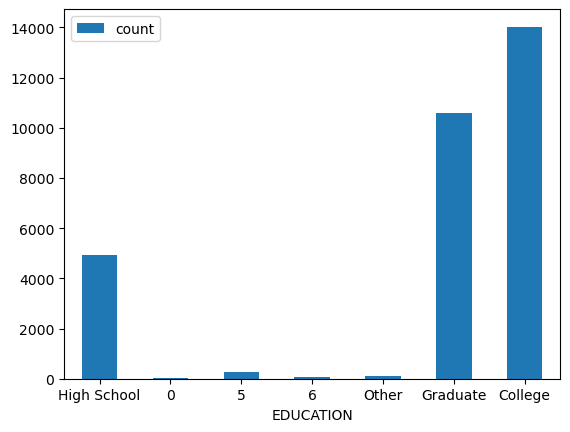

In [46]:
# Create bar plot of EDUCATION
# First, aggregate data
education_cats = spark_df.groupBy('EDUCATION').count()
education_cats.show()
# Then plot data
education_cats.toPandas().plot(x="EDUCATION", y="count", kind="bar", rot=0);

+--------+-----+
|MARRIAGE|count|
+--------+-----+
|       0|   54|
|   Other|  323|
| Married|13658|
|  Single|15964|
+--------+-----+



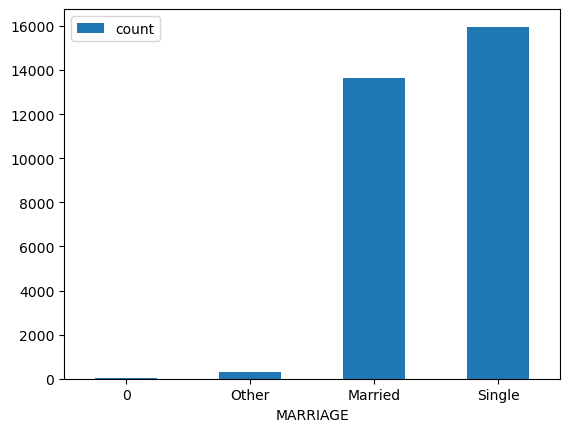

In [47]:
# Create bar plot of MARRIAGE
# First, aggregate data
marriage_cats = spark_df.groupby('MARRIAGE').count()
marriage_cats.show()
# Then plot data
marriage_cats.toPandas().plot(x="MARRIAGE", y="count", kind="bar", rot=0);

It looks like there are barely any records in the `0`, `5`, and `6` categories. Let's go ahead and bin (combine) those with the current `Other` records into a single catch-all `Other` category for both `EDUCATION` and `MARRIAGE`.

In [48]:
#Binning
from pyspark.sql import functions as F
# Bin EDUCATION categories
df_education_binned = spark_df.withColumn('EDUCATION',
                                          F.when(spark_df['EDUCATION'] == '0', 'Other')\
                                          .when(spark_df['EDUCATION'] == '5', 'Other')\
                                          .when(spark_df['EDUCATION'] == '6', 'Other')\
                                          .otherwise(spark_df['EDUCATION'])
                                         )
# Bin MARRIAGE categories
df_all_binned = df_education_binned.withColumn('MARRIAGE',
                                               F.when(df_education_binned['MARRIAGE'] == '0', 'Other')\
                                               .otherwise(df_education_binned['MARRIAGE'])
                                              )

# Select and show all distinct categories for EDUCATION and MARRIGE again
df_all_binned.select('EDUCATION').distinct().show()
df_all_binned.select('MARRIAGE').distinct().show()

+-----------+
|  EDUCATION|
+-----------+
|High School|
|      Other|
|   Graduate|
|    College|
+-----------+

+--------+
|MARRIAGE|
+--------+
|   Other|
| Married|
|  Single|
+--------+



Let's also re-create the plots from earlier, now that the data has been binned:

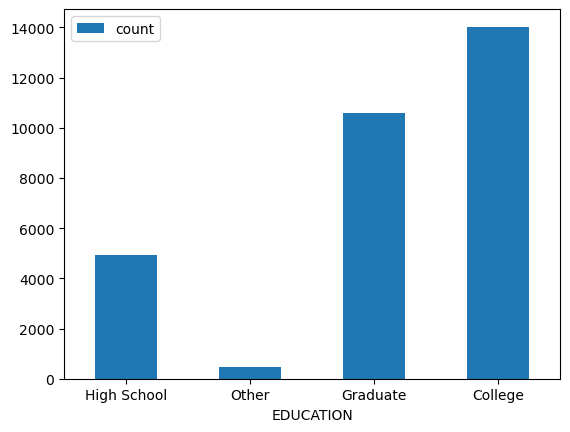

In [49]:
# Plot EDUCATION
df_all_binned.groupBy('EDUCATION')\
             .count()\
             .toPandas()\
             .plot(x="EDUCATION", y="count", kind="bar", rot=0);

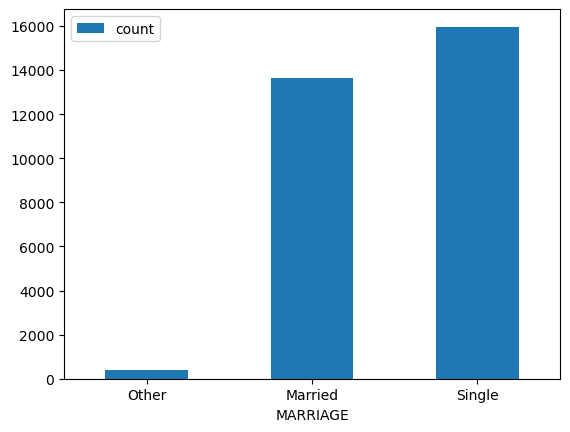

In [50]:
# Plot MARRIAGE
df_all_binned.groupBy('MARRIAGE')\
             .count()\
             .toPandas()\
             .plot(x="MARRIAGE", y="count", kind="bar", rot=0);

Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

Class Balance Exploration

Let's first look at the overall distribution of class balance of the `default` column (the target for our upcoming machine learning process). 

Create a bar plot to compare the number of defaults (`0`) vs. non-defaults (`1`). Consider customizing your plot labels as well, since `0` and `1` are not particularly understandable values.

+-------+-----+
|default|count|
+-------+-----+
|      0|23364|
|      1| 6635|
+-------+-----+



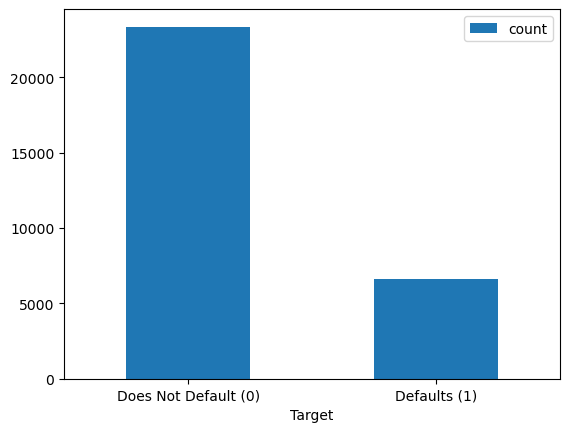

In [51]:
import matplotlib.pyplot as plt

# Group and aggregate target data
target_cats = df_all_binned.groupBy('default').count().orderBy('default')
target_cats.show()

# Plot target data
fig, ax = plt.subplots()
target_cats.toPandas().plot(x='default', y='count', kind='bar', ax=ax, rot=0)
ax.set_xlabel("Target")
ax.set_xticklabels(['Does Not Default (0)','Defaults (1)']);

Looks like we have a fairly imbalanced dataset.

Let's also visualize the difference in default rate between males and females in this dataset. Group by both `default` and `SEX` and visualize the comparison.

+-------+------+-----+
|default|   SEX|count|
+-------+------+-----+
|      0|Female|14349|
|      0|  Male| 9015|
|      1|Female| 3762|
|      1|  Male| 2873|
+-------+------+-----+



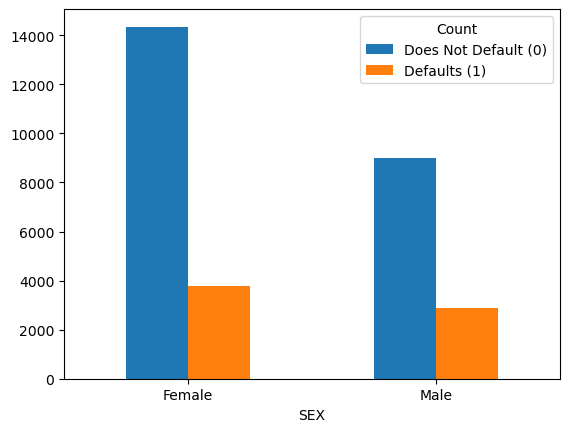

In [52]:
# Group and aggregate target and sex data
target_by_sex = df_all_binned.groupBy(['default', 'SEX']).count().orderBy(['default', 'SEX'])
target_by_sex.show()

# Plot target and sex data
fig, ax = plt.subplots()

target_by_sex.toPandas().pivot(index='SEX', columns='default')\
               .plot(kind='bar', ax=ax, rot=0)

ax.legend(title="Count", labels=['Does Not Default (0)','Defaults (1)']);

It looks like males have an ever so slightly higher default rate than females, and also represent a smaller proportion of the dataset.

Now, it's time to fit the data to the PySpark machine learning model pipeline

In [53]:
# Import the necessary classes
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Create the string indexers and determine the names of the numeric
# and indexed columns
# (You could write this out for all 3 but we'll use a loop approach)
indexers = []
indexed_features = []
numeric_features = []

for column, data_type in df_all_binned.dtypes:
    if data_type == 'string':
        # Create StringIndexers for columns containing strings
        si = StringIndexer(inputCol=column, outputCol=column+'_num', handleInvalid='keep')
        indexers.append(si)
        # Save the name of the output column to sent to the OHE
        indexed_features.append(si.getOutputCol())
    elif column != "ID" and column != "default":
        # Unless it's ID (an identifier rather than a genuine feature),
        # append to list of numeric features if the dtype isn't string
        numeric_features.append(column)

print("Indexed string features:", indexed_features, "\n")
print("Numeric features:", numeric_features, "\n")

# Create a OneHotEncoder to encode the indexed string features
ohe = OneHotEncoder(
    inputCols=indexed_features,
    outputCols=[col + '_ohe' for col in indexed_features],
    dropLast=True
)

# Determine the names of the final list of features going into the model
features = numeric_features + ohe.getOutputCols()
print("Final features:", features, "\n")

# Create a VectorAssembler to combine all features
va = VectorAssembler(inputCols=features , outputCol='features')

# Assemble a list of stages that includes all indexers, the one-hot
# encoder, and the vector assembler
stages = indexers + [ohe, va]
print("Stages:", stages)

Indexed string features: ['SEX_num', 'EDUCATION_num', 'MARRIAGE_num'] 

Numeric features: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 

Final features: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_num_ohe', 'EDUCATION_num_ohe', 'MARRIAGE_num_ohe'] 

Stages: [StringIndexer_908fce9daf43, StringIndexer_499f9a0e73bd, StringIndexer_63572ff67eec, OneHotEncoder_62c5e0ee2841, VectorAssembler_0583c76d61ae]


Great! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [54]:
# Import relevant class
from pyspark.ml.pipeline import Pipeline

# Instantiate a pipeline using stages list
pipe = Pipeline(stages=stages)

# Fit and transform the data using the pipeline, then look at
# the size of the array in the 'features' column
pipe.fit(df_all_binned)\
    .transform(df_all_binned)\
    .head()['features'].size

29

The pipeline has produced a sparse vector with 29 features.

This comes from:
    
* 20 numeric features
* 3 one-hot encoded features with `dropLast=True`, containing
  * 1 SEX feature
  * 3 EDUCATION features
  * 2 MARRIAGE features

That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`.

In [55]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='default',
    metricName='areaUnderROC'
)

In [58]:
#Logistic Regression
#Perform train test split
train, test = df_all_binned.randomSplit(weights=[0.8, 0.2], seed=1)

In [57]:
from pyspark.ml.classification import LogisticRegression

# Train-test split
train, test = df_all_binned.randomSplit(weights=[0.8, 0.2], seed=1)

# Instantiate a logistic regression and add to stages
lr = LogisticRegression(
    featuresCol='features',
    labelCol='default',
    predictionCol='prediction',
    standardization=True
)
lr_stages = stages + [lr]

# Instantiate a new Pipeline with all of the stages
lr_pipe = Pipeline(stages=lr_stages)

# Fit the pipeline on the training data
lr_pipe_fit = lr_pipe.fit(train)

# Transform both train and test data using the pipeline
lr_result_train = lr_pipe_fit.transform(train)
lr_result_test = lr_pipe_fit.transform(test)

# Use evaluator to evaluate performance
print("ROC-AUC on train:", evaluator.evaluate(lr_result_train))
print("ROC-AUC on test:", evaluator.evaluate(lr_result_test))

ROC-AUC on train: 0.6057796783170918
ROC-AUC on test: 0.6090136625813551


Looks like the defaults for `LogisticRegression` are working pretty well, since the train and test metrics are pretty similar.

Still, let's try a `CrossValidator` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)) + `ParamGridBuilder` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)) approach with a few different regularization parameters.

We'll use these regularization parameters:

```python
[0.0, 0.01, 0.1, 1.0]
```

In [59]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Set up param grid
lr_params = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0]).build()

# Set up cross validator
lr_cv = CrossValidator(
    estimator=lr_pipe,
    estimatorParamMaps=lr_params,
    evaluator=evaluator
)

# Fit cross validator on the full dataframe
lr_model = lr_cv.fit(df_all_binned)

In [60]:
# Best model was the first (0-th) one
# (You could also use np.argmax to get this automatically
# instead of manually inspecting the results)
lr_params[0]

{Param(parent='LogisticRegression_c12dd7fcdc36', name='regParam', doc='regularization parameter (>= 0).'): 0.0}

Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. You can find all of the available classification model options [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#classification).

This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated classifier as well as print out the AUC of the best-performing model and the best parameters.

In [61]:
import numpy as np

def create_model(df, preprocessing_stages, classifier, param_grid, evaluator):
    # Fit the cross validator model
    stages_with_classifier = preprocessing_stages + [classifier]
    pipe = Pipeline(stages=stages_with_classifier)
    cv = CrossValidator(
        estimator=pipe,
        estimatorParamMaps=param_grid,
        evaluator=evaluator
    )
    model = cv.fit(df)
    
    # Find and display the best classifier's metric and params
    index_best_clf = np.argmax(model.avgMetrics)
    best_clf_metric = model.avgMetrics[index_best_clf]
    best_clf_params = param_grid[index_best_clf]
    print(f"""
Best {evaluator.getMetricName()}: {best_clf_metric}

Best params: {best_clf_params}
    """)
    
    # Return the model
    return model

Now train one other classifier that is not a `LogisticRegression`. Use a `ParamGridBuilder` to try out some relevant parameters.

In [63]:
# Here we're trying a random forest
# ⏰ This cell may take a long time to run
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features',labelCol='default')
rf_params = ParamGridBuilder()\
 .addGrid(rf.maxDepth, [5,10])\
 .addGrid(rf.numTrees, [20,100])\
 .build()

rf_model = create_model(df_all_binned, stages, rf, rf_params, evaluator)


Best areaUnderROC: 0.6523039861530223

Best params: {Param(parent='RandomForestClassifier_b39179b6e453', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_b39179b6e453', name='numTrees', doc='Number of trees to train (>= 1).'): 100}
    


And one more

In [64]:
# Here we're trying a gradient-boosted trees classifier
# ⏰ This cell may take a long time to run
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol='features',labelCol='default')
gb_params = ParamGridBuilder()\
  .addGrid(gb.maxDepth,[1,5])\
  .addGrid(gb.maxIter,[20,50])\
  .build()

gb_model = create_model(df_all_binned, stages, gb, gb_params, evaluator)


Best areaUnderROC: 0.6605764603772106

Best params: {Param(parent='GBTClassifier_2fff595f3651', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_2fff595f3651', name='maxIter', doc='max number of iterations (>= 0).'): 50}
    


 - Looking at our metrics, the gradient-boosted trees classifier 
and random forest classifier had very similar metrics, wit 
ROC-AUC just above 0.6 . Either would be a strong choice  f
we aren't worried about computational complex.
 - The logistic regression, with ROC-AUC of 0.61, could be our backup plan if we need a less complex model model

In [65]:
spark.stop()